In [19]:
import numpy as np
from control import matlab
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# 9.5 数値シミュレーション
- control.matlab.lqrに最適レギュレータが実装されている
    - 関数から帰ってくるF,X,Eは
        - F:フィードバックゲイン
        - X:リカッチ方程式の解
        - E:閉ループ系の極

In [36]:
output_names = ["発電機端子電圧", "発電機内部相差角"]
input_names = ["励磁機制御系の設定電圧", "タービンへの蒸気流量"]
A = np.array(pd.read_csv("./data/sim1/sys_A.csv", header=None))
B = np.array(pd.read_csv("./data/sim1/sys_b.csv", header=None))
C = np.array(pd.read_csv("./data/sim1/sys_c.csv", header=None))

Pss = matlab.ss(A, B, C, 0)

## 最適レギュレータの設計

In [3]:
# 設計パラメータ
Q = np.diag([10]*9)
R = np.diag([10]*2)

In [4]:
F, X, E = matlab.lqr(Pss.A, Pss.B, Q, R) #ここでリカッチ方程式を解いてる

In [41]:
#固有値の確認
print("元々の固有値")
display(np.linalg.eigvals(A))
print("状態フィードバック系の固有値")
# display(np.linalg.eigvals(A-np.dot(B,F)))
display(E)

元々の固有値


array([-1.06803978e+02+15.80269197j, -1.06803978e+02-15.80269197j,
       -6.22446902e-02+10.4594185j , -6.22446902e-02-10.4594185j ,
       -1.29873340e+01 +0.j        , -3.40349396e+01 +9.95086901j,
       -3.40349396e+01 -9.95086901j, -2.96303407e+01 +0.j        ,
       -5.00000000e+00 +0.j        ])

状態フィードバック系の固有値


array([-107.930374 +15.291009j, -107.930374 -15.291009j,
        -34.78741   +9.299614j,  -34.78741   -9.299614j,
        -29.380627  +0.j      ,   -9.922343 +13.230641j,
         -9.922343 -13.230641j,  -11.765754  +0.j      ,
         -3.1871777 +0.j      ], dtype=complex64)

## 応答の確認

### 状態フィードバックなし

In [56]:
Td = np.arange(0, 2, 0.01) #シミュレーション時間0~1s,0.01s刻み

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A, Pss.B, C, 0)
y, tt = matlab.initial(sys, Td, X0) #線形システムシミュレータ

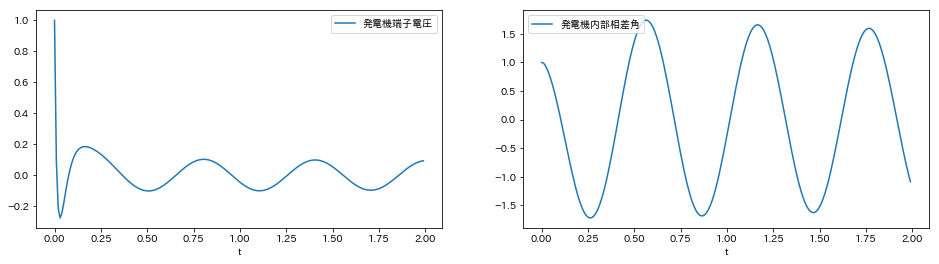

In [57]:
df = pd.concat((pd.DataFrame(tt),pd.DataFrame(y)), axis = 1)
df.columns = ["t", output_names[0], output_names[1]]

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

df.plot(ax = ax1, x = "t", y = output_names[0])
df.plot(ax = ax2, x = "t", y = output_names[1])

plt.show()

### 最適レギュレータで状態フィードバック系を設計

In [58]:
Td = np.arange(0, 5, 0.01) #シミュレーション時間0~1s,0.01s刻み
Ud = 0*(Td>0) #入力信号（ステップ入力）

X0 = [1]*9 # 初期状態量
sys = matlab.ss(Pss.A-np.dot(Pss.B,F), Pss.B, C, 0)
y, tt, x = matlab.lsim(sys, np.vstack((Ud,Ud)).T, Td, X0) #線形システムシミュレータ

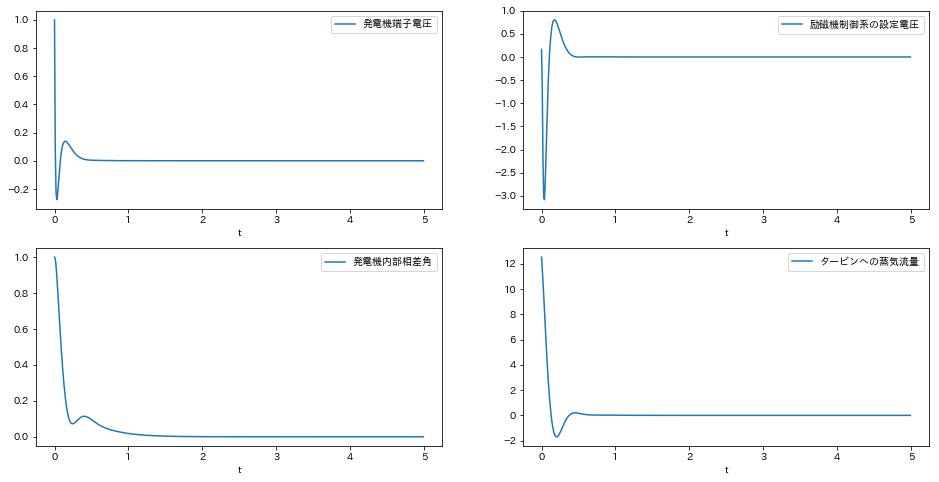

In [59]:
df = pd.concat((pd.DataFrame(tt), pd.DataFrame(y) ,pd.DataFrame(np.dot(x, -F.T))), axis = 1) #u =-Fx 
df.columns = ["t", output_names[0], output_names[1], input_names[0], input_names[1]]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 4)

df.plot(ax = ax1, x = "t", y = output_names[0])
df.plot(ax = ax2, x = "t", y = output_names[1])
df.plot(ax = ax3, x = "t", y = input_names[0])
df.plot(ax = ax4, x = "t", y = input_names[1])

plt.show()

# 演習問題
## 9.2
- まず平方完成すると
    - $(x+2y)^2 + 2(y - z)^2 + (2z + x)^2$ってなって明らかに半正定か正定
- $x^TAx$の形にしたとき$A$が色々作れるけど,A≧0の場合が見つかれば半正定
- 与えられた式から$x^TAx$の形を作ると
    - $A = \left(
    \begin{array}{ccc}
      2 & 4 & 4 \\
      0 & 6 & -4 \\
      0 & 0 & 6
    \end{array}
  \right)$
    - $A = \left(
    \begin{array}{ccc}
      2 & 2 & 2 \\
      2 & 6 & -2 \\
      2 & -2 & 6
    \end{array}
  \right)$
    - とかが作れる

In [72]:
A = np.array([[2,4,4],[0,6,-4],[0,0,6]])
np.linalg.eigvals(A)

array([2., 6., 6.])

- これはすべての固有値が正なので正定行列

In [73]:
A = np.array([[2,2,2],[2,6,-2],[2,-2,6]])
np.linalg.eigvals(A)

array([-4.4408921e-16,  6.0000000e+00,  8.0000000e+00])

- 一個固有値0が出てきたので半正定行列
    - よって与えられた二次形式も半正定

# ハマりメモ1
- slycotモジュールが入ってなくて最初エラーでた
    - `pip install slycot` だけでは入らなかった
        - `sudo apt-get install gfortran`と
        - `sudo apt-get install libblas-dev liblapack-dev`した後もう一度`pip install slycot`したらslycotが入ってlqrもちゃんと走るようになった

# ハマりメモ２
- なぜか`matlab.lsim`実行時にカーネルリスタートする現象が起きた
- 何が効いたのかわからないが以下のようにすると動くようになった
    - slycotのバージョンを0.4.0->0.3.5に落とした
    - その後、numpyのバージョンを上げた
    - jupyter-labじゃなくてjupyter notebookで実行した
    - 